# Exploring 3D ROCurves

Traditionally ROC curves are 2D - signal and background. But our MVA currently has three variables. What can we do in order to understand the ROC curves for that sort of a situation?

## Initalization

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14) # Font size for titles and axes, default is 10
from mpl_toolkits.mplot3d import Axes3D # if this isn't done then the 3d projection isn't known. Aweful UI!
from sklearn.metrics import roc_curve, auc

## Loading Data

Data is stored in a directory somewhere on the server machine. So this is not likely to be portable.
The job number is also kept seperate to make it easy to update everything.

In [25]:
data_location = "..\\..\\MCAResultsData"
jenkins_build = 139

In [26]:
signal_sample_names=["125pi25lt5m", "200pi25lt5m", "400pi50lt5m", "600pi150lt5m", "1000pi400lt5m"]
bib_sample_names=["data15", "data16"]
mj_sample_names=["jz"]

Next, actual loading of the data. If a file isn't there, we don't really care.

In [27]:
def load_mva_data(sample_name):
    """Load the data written out by a MVA training job into an np array.
    Returns null if the csv file can't be found.
    
    Args:
      sample_name: The name of the sample, e.g. data15
    """
    p = "{0}\\{1}\\all-{2}.csv".format(data_location, jenkins_build, sample_name)
    if not os.path.exists(p):
        return None
    return pd.read_csv(p)

def load_mva_data_from_list(lst):
    """Load data for a series of samples. Silently ignore those we can't find
    
    Args:
        lst: List of samples to load
    """
    return {s[0] : s[1] for s in [(sname, load_mva_data(sname)) for sname in lst] if not(s[1] is None)}

In [28]:
signal_samples = load_mva_data_from_list(signal_sample_names)
bib_samples = load_mva_data_from_list(bib_sample_names)
mj_samples = load_mva_data_from_list(mj_sample_names)

## Basic Plots

Make some basic plots of the weights for each simple individually.

In [64]:
def plot_mva_sample(sample_name, sample_data):
    """Plot the HSS, BIB, and MJ all on one plot as a histogram
    
    Args:
      sample_data: The DataFrame that contains the data for this sample
    """
    nbins = 100
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    plt.hist([sample_data[" HSSWeight"], sample_data[" MultijetWeight"], sample_data[" BIBWeight"]],
             weights=[sample_data.Weight, sample_data.Weight, sample_data.Weight],
             bins=nbins,
             histtype = 'step', normed=True,
             color=['red', 'blue', 'green'],
             label=['HSS Weight', 'Multijet Weight', 'BIB Weight'])
    #plt.hist(sample_data[" HSSWeight"], bins=nbins, weights=sample_data.Weight, histtype = 'step', normed=True, alpha=0.6, color='red', label='HSS Weight')
    #plt.hist(sample_data[" MultijetWeight"], bins=nbins, weights=sample_data.Weight, histtype = 'step', normed=True, alpha=0.6, color='blue', label='Multijet Weight')
    #plt.hist(sample_data[" BIBWeight"], bins=nbins, weights=sample_data.Weight, histtype = 'step', normed=True, alpha=0.6, color='green', label='BIB Weight')
    plt.title("BDT Weights for Sample {0}".format(sample_name))
    plt.xlabel('MVA Weight')
    plt.legend()
    ax.set_yscale('log')
    
def plot_mva_samples(dict_of_samples):
    for k in dict_of_samples.keys():
        plot_mva_sample(k, dict_of_samples[k])
        plt.show()

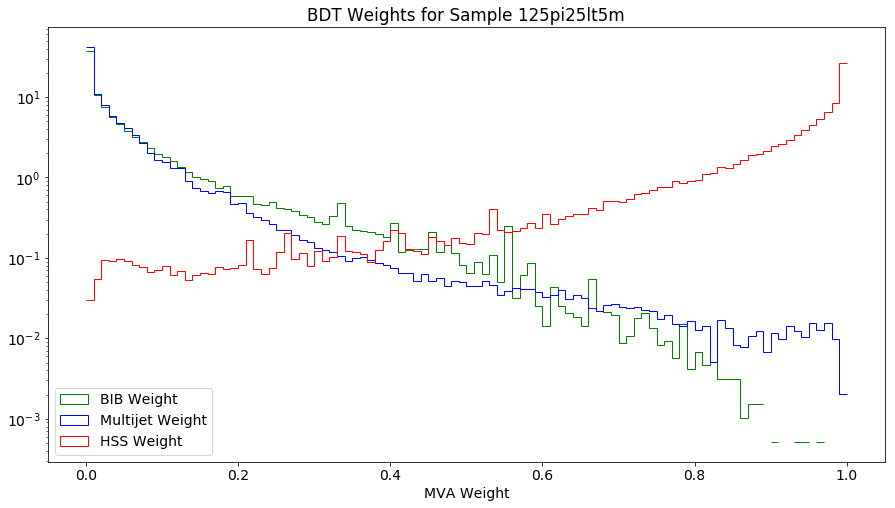

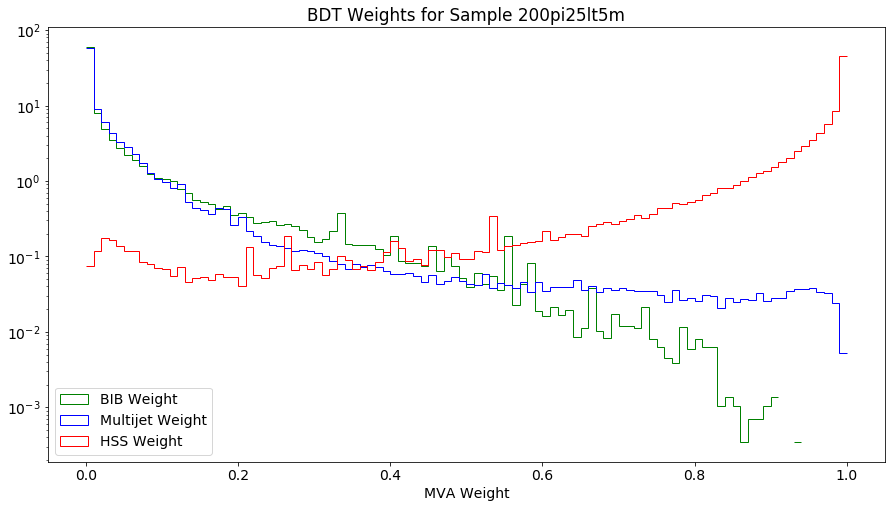

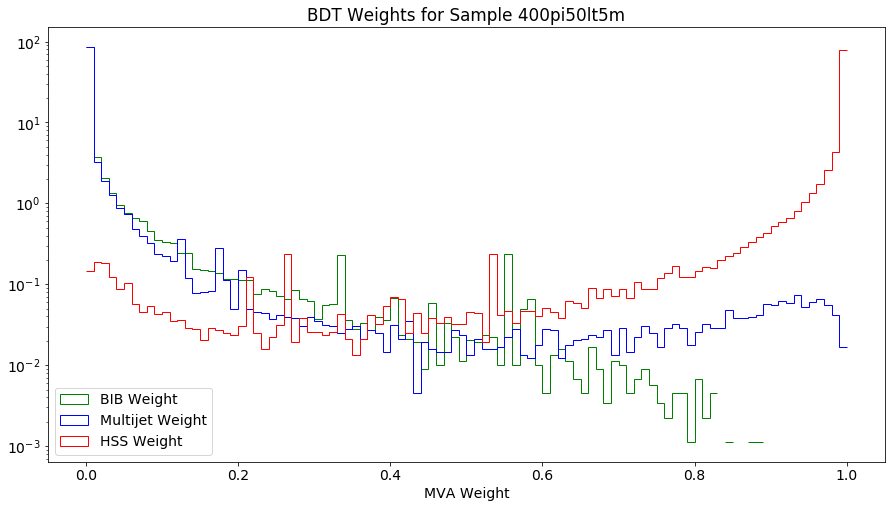

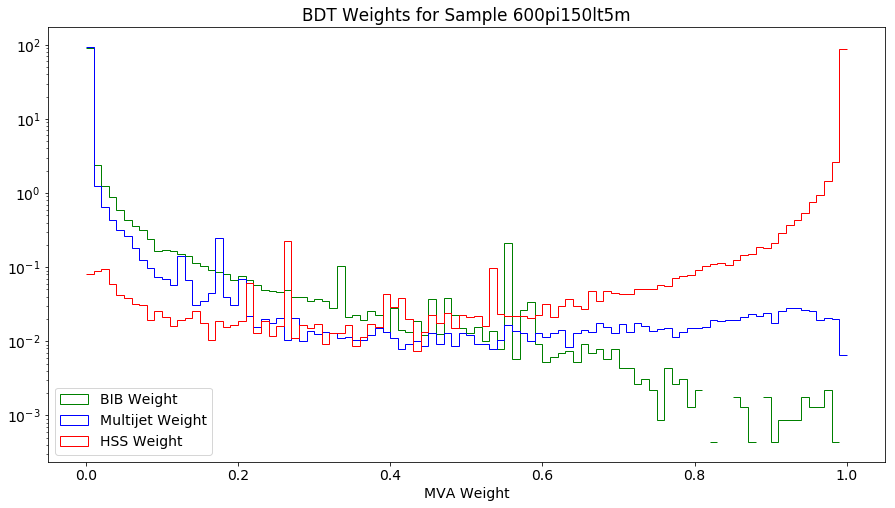

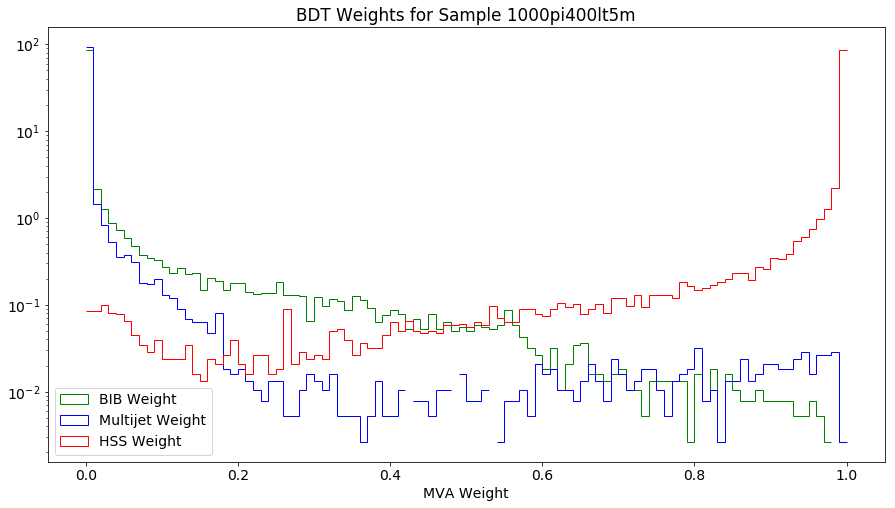

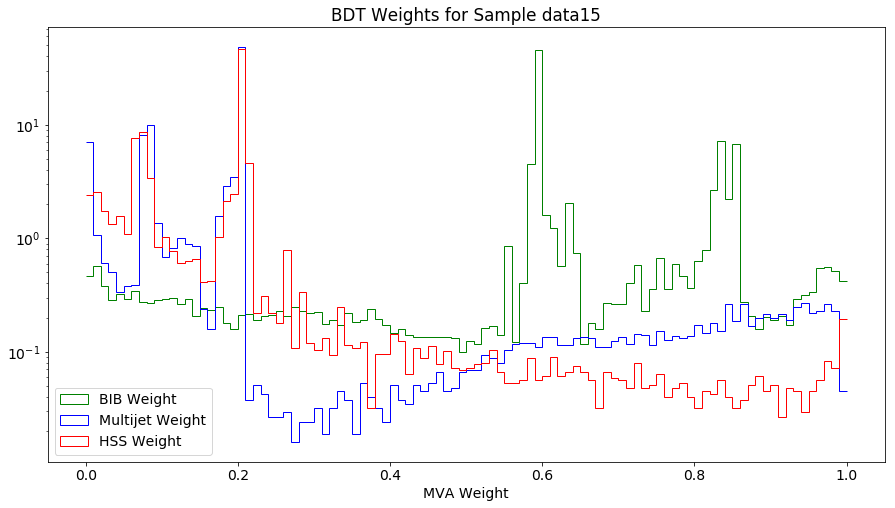

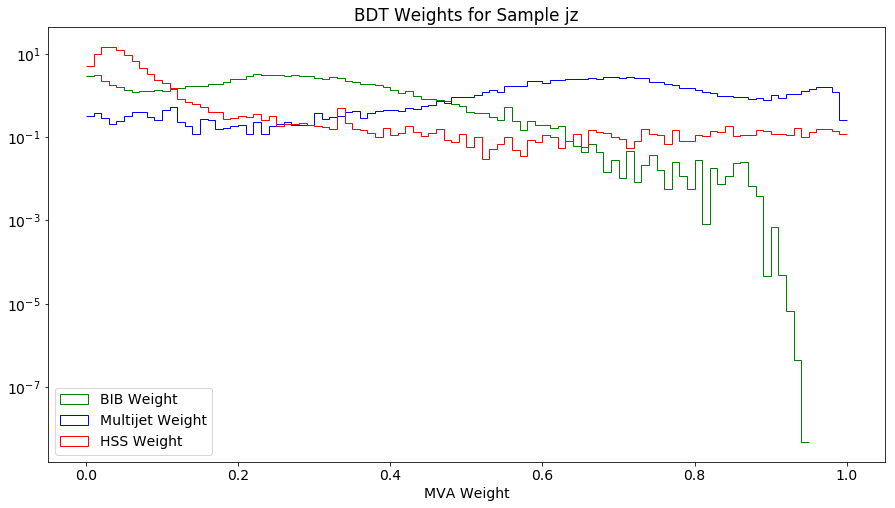

In [65]:
plot_mva_samples({**signal_samples, **bib_samples, **mj_samples})

## 3D Scatter Plots

Plotting a full 3D scatter plot is very time consuming! It takes more than 5 minutes on my computer. So becareful executing through this guy.

In [8]:
def plot_mva_scatter_plot (sample_name, signal_data, bib_data, background_data):
    """Plot the results as a scatter plot for """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    args = {'marker': '.'}
    
    ax.scatter(signal_data[" HSSWeight"], signal_data[" MultijetWeight"], signal_data[" BIBWeight"], color='b', **args)
    ax.scatter(bib_data[" HSSWeight"], bib_data[" MultijetWeight"], bib_data[" BIBWeight"], color='g', **args)
    ax.scatter(background_data[" HSSWeight"], background_data[" MultijetWeight"], background_data[" BIBWeight"], color='r', **args)
    ax.set_xlabel('HSS')
    ax.set_ylabel('Multijet')
    ax.set_zlabel('BIB')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_zlim([0.0, 1.0])
    plt.show()

In [9]:
#plot_mva_scatter_plot("dude", signal_samples["125pi25lt5m"], bib_samples["data15"], mj_samples["jz"])

## ROC Curves

Look at ROC curves as a function of BIB cut.

These are mutli-class results - so w_hss + w_mj + w_bib = 1.0. Yet for the ROC curve we have to look at a single weight.

In [66]:
def roc_curve_calc(signal, background, weight=' HSSWeight'):
    '''Calculate a ROC curve
    
    Args:
        signal - data frame that contains the signal
        background - data frame that contains teh background
        weight - the column in the DataFrame that we pull the weights from
        
    Returns
        tpr - true positive rate
        fpr - false postive rate
        auc - Area under the curve for the tpr/fpr curve - bigger is better!
    '''
    # build a single array marking one as signal and the other as background
    truth = np.concatenate((np.ones(len(signal.index)), np.zeros(len(background.index))))
    score = np.concatenate((signal[weight], background[weight]))
    (fpr, tpr, thresholds) = roc_curve(truth,score)
    
    a = auc(fpr, tpr)
    
    return (tpr, fpr, a)

def plot_roc_curve (tpr, fpr, aroc, signal_name = 'Signal', background_name = 'JZ'):
    '''Plot a ROC curve
    
    Args:
        tpr - True positive rate
        fpr = False postiive rate
        aroc - the area under the curve (in the legend)
        signal_name - for the signal axis label
        background_name - for the background axis name
    '''
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange', label='ROC Curve area {0:0.2f}'.format(aroc))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('{0} Positive Rate'.format(signal_name))
    plt.xlabel('{0} Postiive Rate'.format(background_name))
    plt.legend()

In [67]:
tpr, fpr, aroc = roc_curve_calc(signal_samples["125pi25lt5m"], mj_samples["jz"])

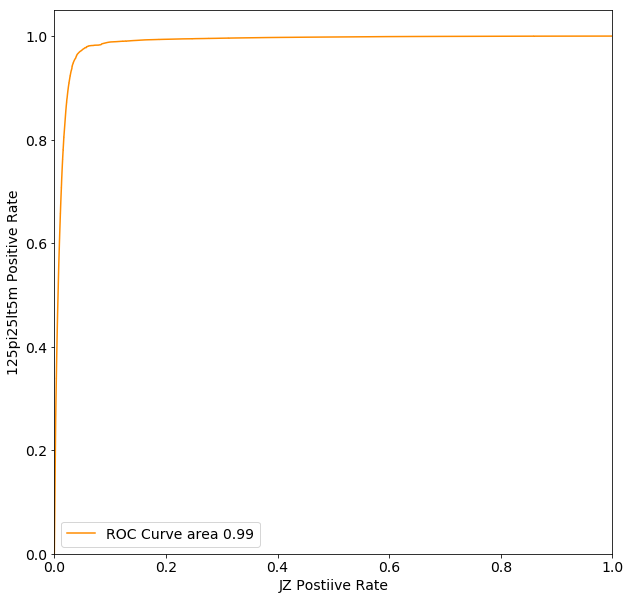

In [68]:
plot_roc_curve(tpr, fpr, aroc, signal_name = "125pi25lt5m")
plt.show()

In [42]:
def calc_roc_with_bib_cut (sig, back, bib, bib_cut = 0.5):
    '''Calc ROC curve basics after limiting the data sample for a particular bib cut
    
    Args:
        sig - signal DataFrame
        back - background DataFrame
        bib - the bib sample
        bib_cut - only events with a bib value less than this number will be included
        
    Returns:
        tpr - true positive rate
        fpr - false positive rate
        aroc - area under the ROC curve
        sig_eff - How much signal this bib cut removed
        back_eff - how much background this bib cut removed
        bib_eff
    '''
    gsig = sig[sig[' BIBWeight']<bib_cut]
    sig_eff = len(gsig.index)/len(sig.index)
    gback = back[back[' BIBWeight']<bib_cut]
    back_eff = len(gback.index)/len(back.index)
    gbib = bib[bib[' BIBWeight']<bib_cut]
    bib_eff = len(gbib.index)/len(bib.index)
    
    tpr, fpr, aroc = roc_curve_calc(gsig, gback)
    
    return (tpr, fpr, aroc, sig_eff, back_eff, bib_eff)

def calc_roc_family (sig, back, bib, bib_cut_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    all = [calc_roc_with_bib_cut (sig, back, bib, bib_cut = bc)+(bc,) for bc in bib_cut_range]
    return pd.DataFrame(all, columns=['tpr', 'fpr', 'aroc', 'sig_eff', 'back_eff', 'bib_eff', 'bib_cut'])

In [43]:
p125 = calc_roc_family(signal_samples["125pi25lt5m"], mj_samples["jz"], bib_samples['data15'])

In [44]:
p125

,tpr,fpr,aroc,sig_eff,back_eff,bib_eff,bib_cut
0,"[0.0, 0.00934543123045, 0.0125771499997, 0.014...","[0.0, 0.000127126185452, 0.000175300318886, 0....",0.987679,0.792680,0.498194,0.034916,0.1
1,"[0.0, 0.00820963878727, 0.0110485921863, 0.012...","[0.0, 9.53601753824e-05, 0.000131496662896, 0....",0.987643,0.902347,0.664151,0.059130,0.2
2,"[0.0, 0.00782249495848, 0.0105275711777, 0.012...","[0.0, 7.63139249617e-05, 0.000105232886, 0.000...",0.987992,0.947005,0.829908,0.080803,0.3
3,"[0.0, 0.00761108063631, 0.0102430482299, 0.011...","[0.0, 6.70791682466e-05, 9.24986425295e-05, 0....",0.987680,0.973310,0.944161,0.100522,0.4
4,"[0.0, 0.00749968816265, 0.0100931354206, 0.011...","[0.0, 6.4555015483e-05, 8.90179687187e-05, 0.0...",0.987228,0.987766,0.981079,0.114060,0.5
5,"[0.0, 0.00743764593094, 0.0100096385294, 0.011...","[0.0, 6.3710755851e-05, 8.78537791208e-05, 0.0...",0.986847,0.996006,0.994079,0.638689,0.6
6,"[0.0, 0.00741871799617, 0.00998416517573, 0.01...","[0.0, 6.3458939728e-05, 8.75065379408e-05, 0.0...",0.986708,0.998547,0.998024,0.710716,0.7
7,"[0.0, 0.00741029841472, 0.00997283404115, 0.01...","[0.0, 6.3400834088e-05, 8.74264133214e-05, 0.0...",0.986602,0.999682,0.998939,0.753525,0.8
8,"[0.0, 0.00740809191578, 0.00996986451868, 0.01...","[0.0, 6.33369224256e-05, 8.73382825027e-05, 0....",0.986561,0.999979,0.999947,0.964388,0.9
9,"[0.0, 0.00740793979188, 0.00996965978921, 0.01...","[0.0, 6.33335444451e-05, 8.73336244454e-05, 0....",0.986553,1.000000,1.000000,1.000000,1.0


In [45]:
p_samples = {sname:calc_roc_family(signal_samples[sname], mj_samples["jz"], bib_samples['data15']) for sname in signal_samples.keys()}

Lets look at the eff plot for all samples as a function of the bib cut

In [69]:
def plot_eff_for_bib(ps, sample_name):
    plt.figure(figsize=(10,10))
    plt.plot(ps.bib_cut,ps.sig_eff, label='Sample {0}'.format(sample_name))
    plt.plot(ps.bib_cut,ps.back_eff, label='Sample JZ')
    plt.plot(ps.bib_cut,ps.bib_eff, label='Sample BIB')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('BIB Cut (all events with a BIB value less than this included)')
    plt.ylabel('Fraction of Events')
    plt.title('{0}, JZ, and BIB Efficiencies as a function of BIB cut'.format(sample_name))
    plt.legend()

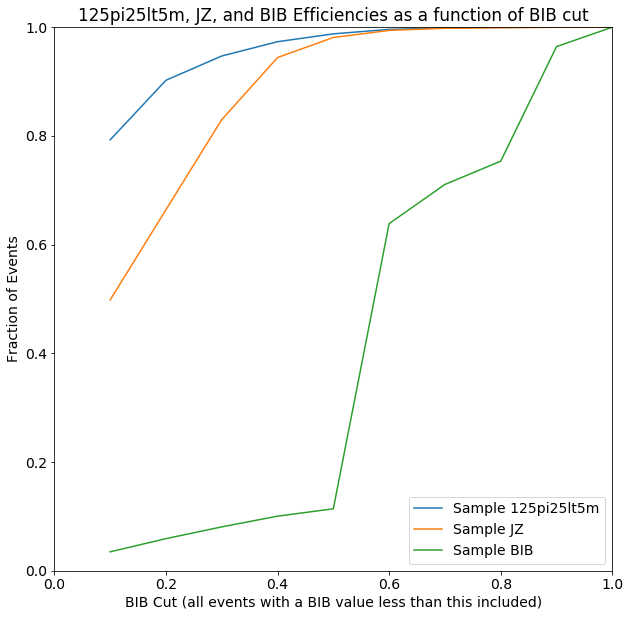

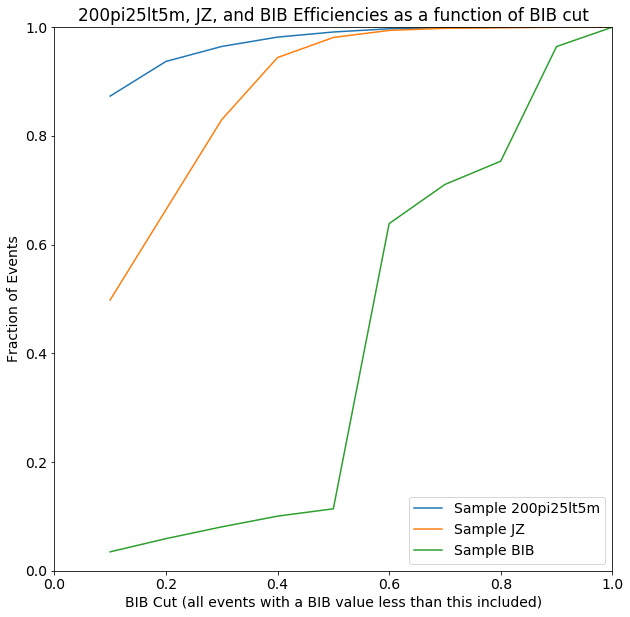

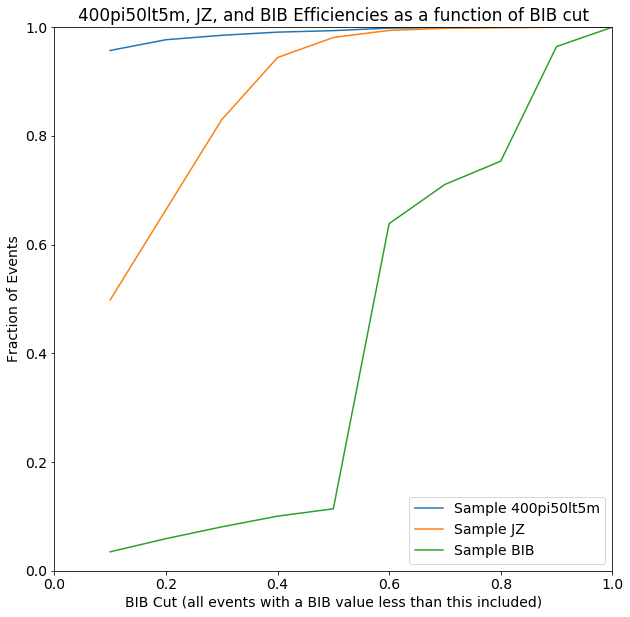

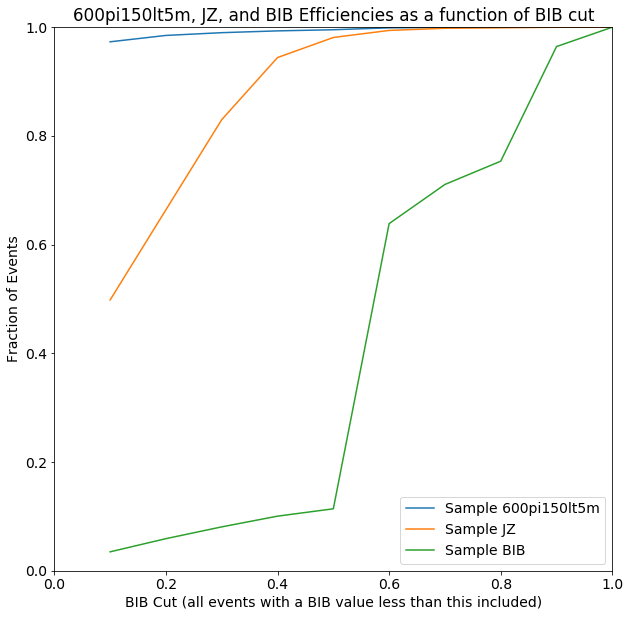

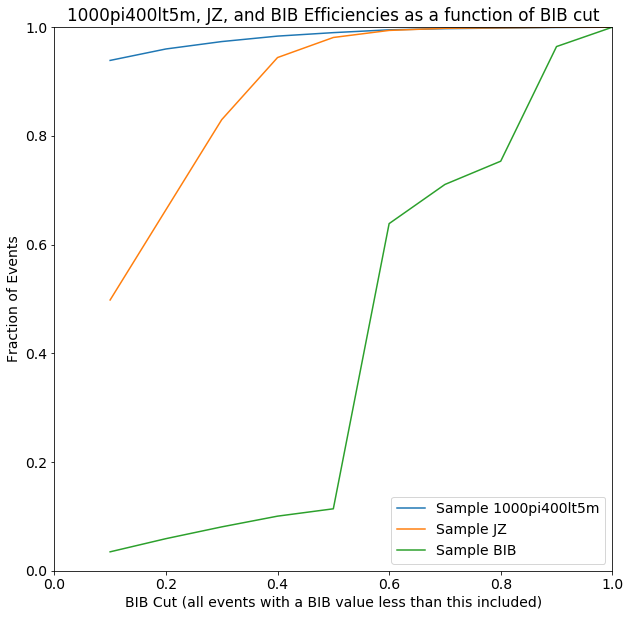

In [70]:
for sname in p_samples.keys():
    plot_eff_for_bib(p_samples[sname], sname)
    plt.show()

Try plotting the family of signal efficencies on the same plot

In [71]:
def plot_all_eff_for_bib(samples):
    plt.figure(figsize=(10,10))
    # Do the eff samples
    for s in samples:
        plt.plot(samples[s].bib_cut,samples[s].sig_eff, label='Sample {0}'.format(s))
    # Do the background
    abck=samples[list(samples.keys())[0]]
    plt.plot(abck.bib_cut,abck.back_eff, label='Sample JZ')
    plt.plot(abck.bib_cut,abck.bib_eff, label='Sample BIB')
    # Get the plot in shape
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('BIB Cut (all events with a BIB value less than this included)')
    plt.ylabel('Fraction of Events')
    plt.title('Signal, JZ, and BIB Efficiencies as a function of BIB cut')
    plt.legend()

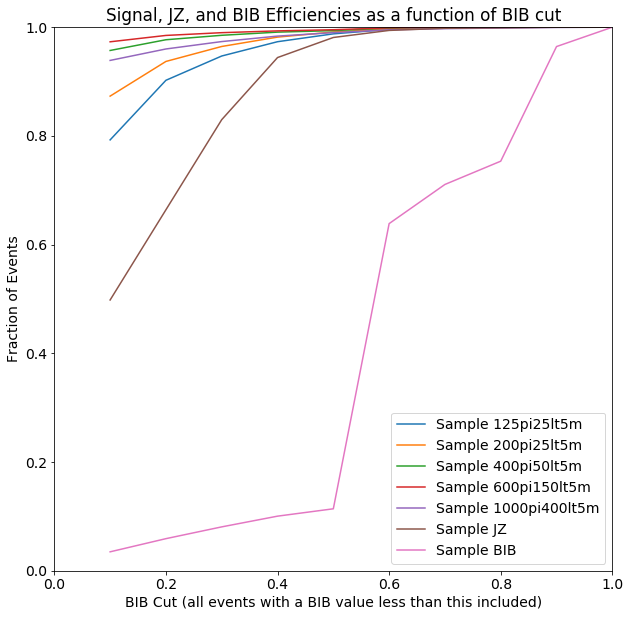

In [72]:
plot_all_eff_for_bib(p_samples)
plt.show()

Look at a faimly of ROC plots now, for each BIB cut

In [74]:
def plot_roc_family_sample(sample_info_bib, sample_name, background_name = 'jz'):
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)
    for index,r in sample_info_bib.iterrows():
        sig_scale = r.sig_eff
        back_scale = r.back_eff
        ax.plot(r.fpr*back_scale, r.tpr*sig_scale, label='BIB Cut {0:0.2f} eff={1:0.2f} (AROC={2:0.3f})'.format(r.bib_cut, r.bib_eff, r.aroc))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('{0} Positive Rate'.format(sample_name))
    plt.xlabel('{0} Postiive Rate'.format(background_name))
    plt.title('ROC curves for {0} as a function of BIB cut'.format(sample_name))
    plt.legend()

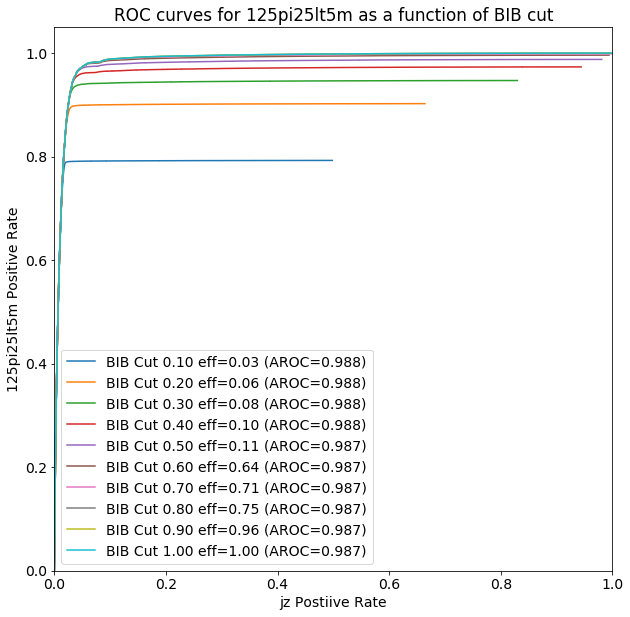

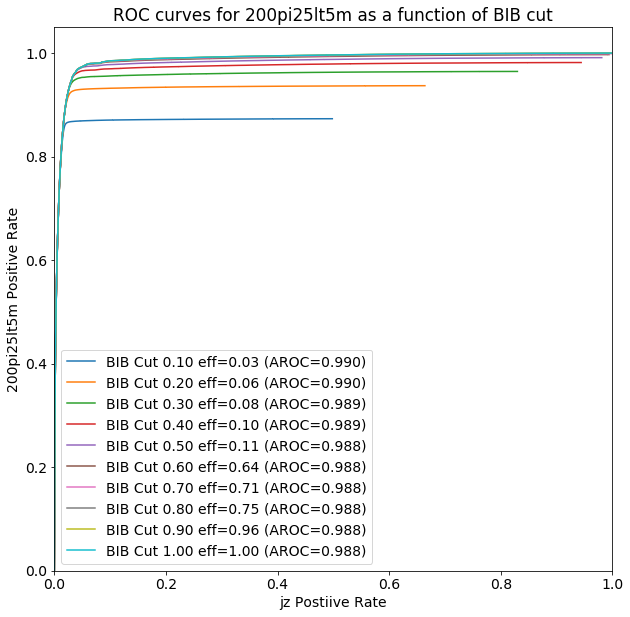

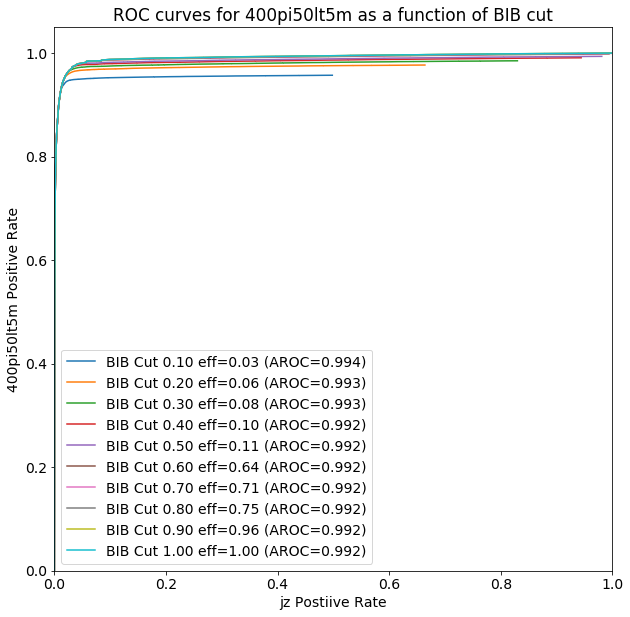

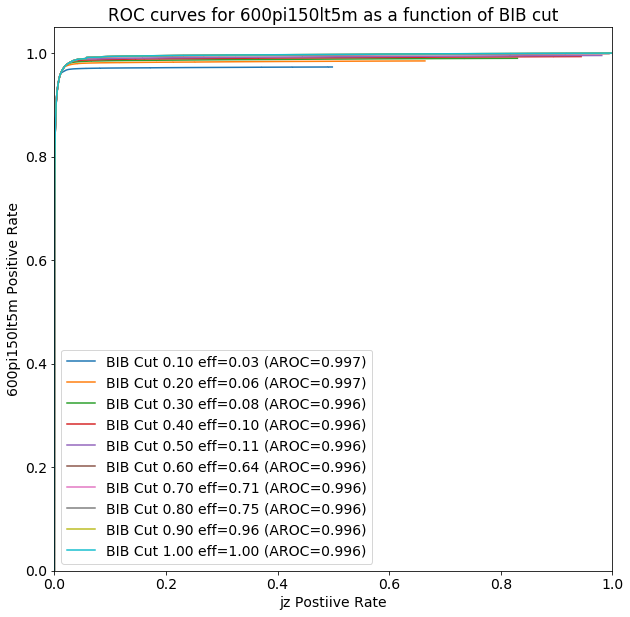

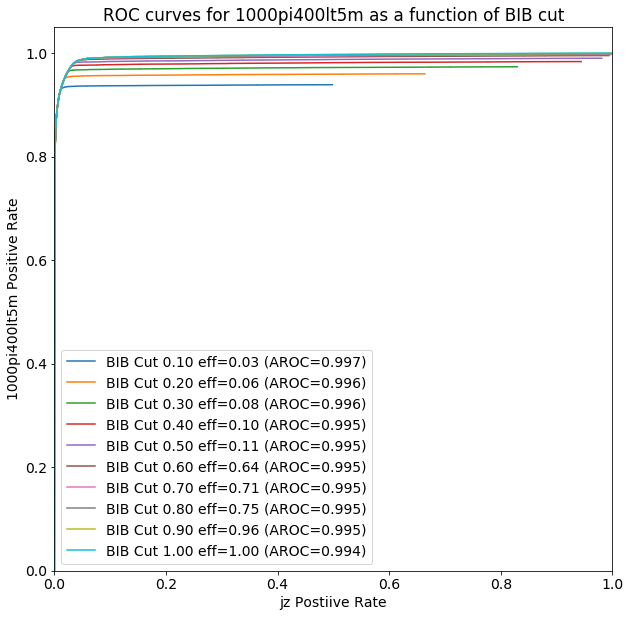

In [75]:
for sname in p_samples.keys():
    plot_roc_family_sample(p_samples[sname], sname)
    plt.show()